In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython import display
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import os.path
from datetime import datetime

from normals import compute_normals
from point_dataset import PointDataset
from sirens import Siren, gradient
from occupancy_networks import OccupancyNetwork
from igr import IGR
from torch_utils import *

sns.set_theme()

In [2]:
def visualize_normals(pc, normals, limits=[[-1, 1], [-1, 1]]):
    fig, ax = plt.subplots()
    ax.quiver(pc[:, 0], pc[:, 1], normals[:, 0], normals[:, 1])
    ax.set_xlim([limits[0][0], limits[0][1]])
    ax.set_ylim([limits[1][0], limits[1][1]])
    ax.set_aspect('equal')
    plt.show()

def visualize_sdf(sdf, steps=24, extent=[-1, 1, -1, 1], device='cuda'):
    with torch.enable_grad():
        x = torch.linspace(extent[0], extent[1], steps=steps, device=device)
        y = torch.linspace(extent[0], extent[1], steps=steps, device=device)
        mgrid = torch.meshgrid([x, y])
        grid = torch.stack(mgrid, dim=-1).view(-1, 2)
        v, samples = sdf.to(device)(grid)
        gc = gradient(v, samples)

        x = mgrid[0].detach().cpu().numpy()
        y = mgrid[1].detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        gc = gc.detach().cpu().numpy()
    
    v = v.reshape(steps, steps).T
    k = gc[:, 0].copy().reshape(steps, steps).T
    l = gc[:, 1].copy().reshape(steps, steps).T
    
    display.clear_output(wait=True)
    
    heat_fig, heat_ax = plt.subplots()
    heat_ax = sns.heatmap(v, 
                          #annot=True, fmt=".1f",
                          vmin=-1, vmax=1, center=0.0,
                          cmap="RdBu_r")
    heat_ax.set_aspect('equal')
    
    display.display(plt.gcf())
    
    contour_fig, contour_ax = plt.subplots()
    contour_ax.set_aspect('equal')
    cs = contour_ax.contour(x, y, v)
    display.display(plt.gcf())
    
    normals_fig, normals_ax = plt.subplots()
    normals_ax.set_aspect('equal')
    quiver = normals_ax.quiver(k, l)
    
    display.display(plt.gcf())

In [3]:
def get_pc(n=128):
    theta = torch.linspace(0, 2 * np.pi, steps=n)
    radius = 0.75
    return torch.stack((radius * torch.cos(theta), 
                        radius * torch.sin(theta)), dim=-1)

def get_butterfly(n=1024):
    theta = torch.linspace(0, 2 * np.pi, steps=n)
    radius = ((torch.cos(5.0 * theta) ** 2.0) + torch.sin(3 * theta) + 0.3) / 3.0
    return torch.stack((radius * torch.cos(theta),
                        radius * torch.sin(theta)), dim=-1)

def compute_normals_2D(pc, ego):
    pc = torch.cat((pc, torch.ones(pc.shape[:-1] + (1,))), dim=-1)
    return -compute_normals(pc, ego, False, True)[:, :2]

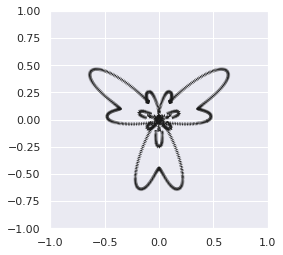

In [4]:
pc = get_butterfly()
#pc = get_pc(128)
normals = compute_normals_2D(pc, torch.tensor([[0.0, 0.0, 0.0]]))
visualize_normals(pc, normals)

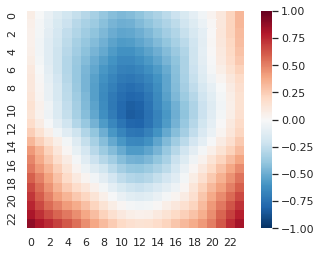

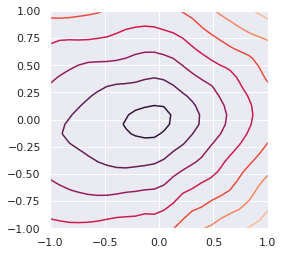

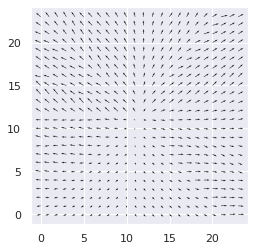

In [ ]:
%matplotlib inline

dset = PointDataset(pc, normals)
loader = DataLoader(dset, batch_size=32, shuffle=True)

'''model = Siren(in_features=2, 
                 out_features=1, 
                 hidden_features=32,
                 hidden_layers=3,
                 outermost_linear=False)'''
#model = OccupancyNetwork(input_dims=2)
model = IGR(input_dims=2, depths=[32, 32, 32, 32, 32, 32])
model = model.cuda()

'''
lr = 1e-4
vis_epochs = 100
'''
lr = 1e-4
vis_epochs = 100

optim = torch.optim.Adam(lr=lr, params=model.parameters())

c_reconstruction = 3e3 # 1.0
c_eikonal = 5e1 # 1.0
c_inter = 1e2 # 1.0
c_normals = 1e2

writer = SummaryWriter(os.path.join('logs', '2D_experiment', 
                                    datetime.now().strftime("%Y%m%d-%H%M%S"))
                      )

for epoch in range(100000):
    for point_batch, normals_batch in loader:
        point_batch = point_batch.cuda()
        normals_batch = -normals_batch.cuda()
        
        model_output, coords = model(point_batch)
        
        inter_pts = trand(point_batch.shape).cuda() - 0.5
        inter_samples, inter_coords = model(inter_pts)
        gc = gradient(inter_samples, inter_coords)
        gc_level_set = gradient(model_output, coords)
        
        l_reconstruction = (model_output ** 2).mean() * c_reconstruction
        l_eikonal = ((1.0 - (gc[:, 0] ** 2 + gc[:, 1] ** 2) ** 2) ** 2).mean() * c_eikonal
        l_inter = torch.exp(-1e2 * torch.abs(inter_samples)).mean() * c_inter
        l_normals = (1 - torch.nn.functional.cosine_similarity(normals_batch, gc_level_set, dim=-1).mean()) * c_normals
        
        loss = l_reconstruction + l_eikonal + c_inter + l_normals
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    with torch.no_grad():
        writer.add_scalar('Reconstruction Loss', 
                   l_reconstruction.item(), 
                   global_step=epoch)
        writer.add_scalar('Eikonal Loss', 
                   l_eikonal.item(), 
                   global_step=epoch)
        writer.add_scalar('Manifold Loss', 
                   l_inter.item(), 
                   global_step=epoch)
        writer.add_scalar('Normals Loss', 
                   l_normals.item(), 
                   global_step=epoch)
        writer.flush()
        if epoch % vis_epochs == 0:
            visualize_sdf(model)